# CNN for **Brain** Tumor Detection Using Pytorch

In [1]:
!pip install split-folders

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

# Step 2: Specify the path to the zip file in Google Drive
#zip_file_path = '/content/drive/MyDrive/Brain Tumor Data Set/archive(1).zip'
#extract_dir = '/content/drive/MyDrive/Brain Tumor Data Set'

# Ensure the extract directory exists
#os.makedirs(extract_dir, exist_ok=True)

# Step 3: Unzip the file
#with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
 #   zip_ref.extractall(extract_dir)

In [5]:
os.listdir("/content/drive/MyDrive/Brain Tumor Data Set")

['Testing', 'Training']

In [6]:
data_dir = "/content/drive/MyDrive/Brain Tumor Data Set"
data_dir = pathlib.Path(data_dir)



In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [8]:
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Testing'), transform=transform)
val_set.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [9]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /content/drive/MyDrive/Brain Tumor Data Set/Training
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


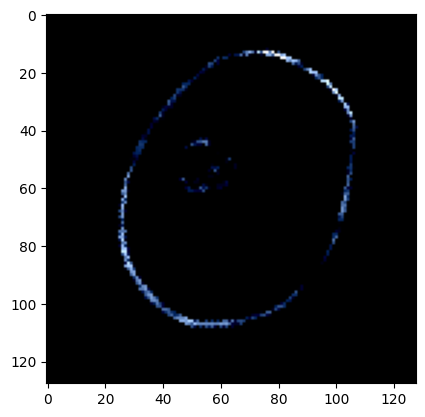

In [10]:
img, label = train_set[1000]
plt.imshow(img.permute(1,2,0))

In [16]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [17]:
next(iter(val_loader))[0].shape

torch.Size([32, 3, 128, 128])

In [18]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    #Conv 1
    self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

    #Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

    #Conv 2
    self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

    #Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

    #Conv 3
    self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

    #Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

    #Conv 4
    self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

    #Max Pool 4
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

    #Activation Function
    self.leakyRelu = nn.LeakyReLU()

    #Fully connected Layer 1
    self.fc1 = nn.Linear(128*4*4, 1024)

    #Fully connected Layer 2
    self.fc2 = nn.Linear(1024, 2)

  def forward(self, x):
    #Layer 1
    out = self.leakyRelu(self.cnv1(x))
    out = self.maxpool1(out)

    #Layer 2
    out = self.leakyRelu(self.cnv2(out))
    out = self.maxpool2(out)

    #Layer 3
    out = self.leakyRelu(self.cnv3(out))
    out = self.maxpool3(out)

    #Layer 4
    out = self.leakyRelu(self.cnv4(out))
    out = self.maxpool4(out)

    #flatten
    out = out.view(out.size(0), -1)

    # Linear Function
    out = self.leakyRelu(self.fc1(out))
    out = self.fc2(out)

    return out



In [19]:
# Training CNN
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [20]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Acciracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 0.6978961825370789
Loss in Iteration: 1 : 0.43448230624198914
Loss in Iteration: 2 : 0.9028152227401733
Loss in Iteration: 3 : 0.3899657130241394
Loss in Iteration: 4 : 0.5286238789558411
Loss in Iteration: 5 : 0.5918919444084167
Loss in Iteration: 6 : 0.5903303623199463
Loss in Iteration: 7 : 0.5554271936416626
Loss in Iteration: 8 : 0.5700969099998474
Loss in Iteration: 9 : 0.5571432113647461
Loss in Iteration: 10 : 0.4788370430469513
Loss in Iteration: 11 : 0.4109315276145935
Loss in Iteration: 12 : 0.2677461504936218
Loss in Iteration: 13 : 0.1600886732339859
Loss in Iteration: 14 : 0.4433957040309906
Loss in Iteration: 15 : 0.2661662697792053
Loss in Iteration: 16 : 0.1941206455230713
Loss in Iteration: 17 : 0.2724928557872772
Loss in Iteration: 18 : 0.3573243021965027
Loss in Iteration: 19 : 0.4152309000492096
Loss in Iteration: 20 : 0.4888158440589905
Loss in Iteration: 21 : 0.2795163691043854
Loss in Iteration: 22 : 0.2637743055820465
Loss in Iteration: 2

In [21]:
train_loss_list

[0.3444259289238188,
 0.2646005029893584,
 0.2185926633162631,
 0.2181337971654203,
 0.16933303657505247,
 0.16413609082034478,
 0.13379529111294283,
 0.1348846124071214,
 0.1180827310308814,
 0.11059825078894694]

In [22]:
val_loss_list

[1.078054735293755,
 0.7545294990906348,
 0.6240328985911149,
 0.8824841334269597,
 0.7445102471571702,
 0.591264376273522,
 0.6286684480997232,
 0.5899313355867679,
 0.6512534893476046,
 0.3904152294764152]

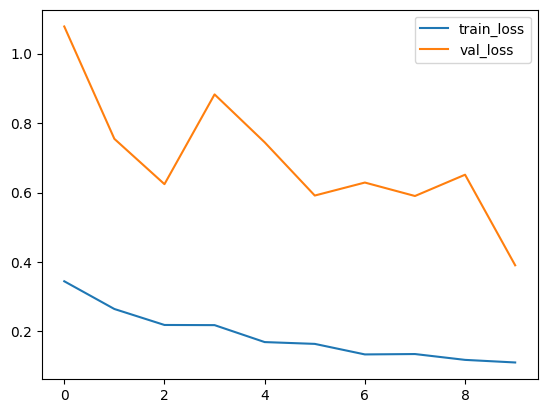

In [23]:
plt.plot(range(num_epochs), train_loss_list,label='train_loss')
plt.plot(range(num_epochs), val_loss_list,label='val_loss')
plt.legend()


In [24]:
accuracy_list

[tensor(51.5228),
 tensor(49.2386),
 tensor(62.9442),
 tensor(52.2843),
 tensor(72.8426),
 tensor(74.3655),
 tensor(74.6193),
 tensor(76.1421),
 tensor(72.5888),
 tensor(84.0102)]

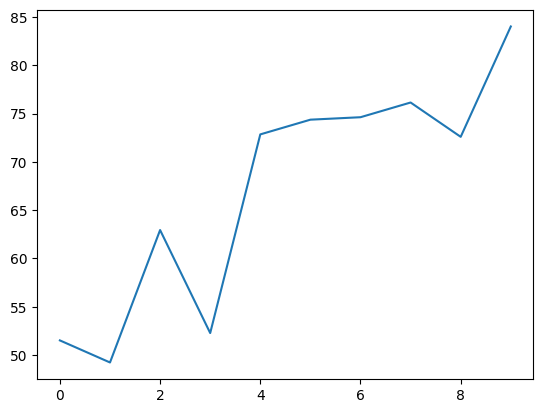

In [25]:
plt.plot(range(num_epochs), accuracy_list)

Text(0.5, 1.0, '1')

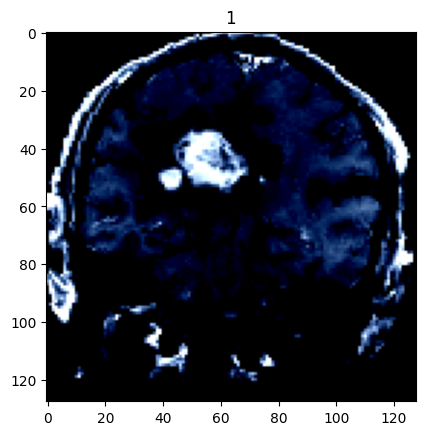

In [26]:
img, label = val_set[110]
plt.imshow(img.permute(1,2,0))
plt.title(label)